In [1]:
# Dependencies
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# CovidActNow API Key
from config import api_key
# Census API Key
from config import census_key

In [2]:
# Create state population dataframe

# Specify the Census URL
census_url = "https://api.census.gov/data/2021/pep/population?"
# Build Census Pops by state query URL
census_query_url = f"{census_url}get=DENSITY_2021,POP_2021,NAME,STATE&for=state:*&key={census_key}"

# Make state pops data request and save to a dataframe
pops_response = requests.get(census_query_url)
pops_json = pops_response.json()
row_counter = len(pops_json)
pops_data = []
for row in range(1, row_counter):
    pops_data.append(pops_json[row])
pops_data_df = pd.DataFrame(pops_data, columns = pops_json[0])

# Create new dataframe with only the needed data columns
reduced_pops_data_df = pops_data_df[["NAME", "POP_2021"]]

# Create dataframe that contains state name and ID
state_id = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY",
            "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH",
            "OK", "OR", "PA", "PR", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
state_list = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", 
              "District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas",
              "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi",
              "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", 
              "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", 
              "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", 
              "West Virginia", "Wisconsin", "Wyoming"]
state_id_df = pd.DataFrame({"NAME" : state_list,
                            "state" : state_id})

# Combine the data into a single dataset
state_pops_data_df = pd.merge(state_id_df, reduced_pops_data_df, on = "NAME", how = "left", sort = False)

In [3]:
# Convert Population data type to float
state_pops_data_df["POP_2021"] = state_pops_data_df["POP_2021"].astype(float)
# Display preview of state population dataframe
state_pops_data_df.head()

,NAME,state,POP_2021
0,Alabama,AL,5039877.0
1,Alaska,AK,732673.0
2,Arizona,AZ,7276316.0
3,Arkansas,AR,3025891.0
4,California,CA,39237836.0


In [4]:
# Create Covid dataframe

# Specify the Covid URL
covid_url = "https://api.covidactnow.org/v2/states.timeseries.csv?apiKey="
# Build CovidActNow query URL
covid_query_url = f"{covid_url}{api_key}"

# Make Covid data request and save to a CSV file
covid_url_response = requests.get(covid_query_url)
covid_url_content = covid_url_response.content
csv_file = open('covid_data.csv', 'wb')
csv_file.write(covid_url_content)
csv_file.close()

# Path to the Covid data file
covid_data_path = "covid_data.csv"
# Read the CSV file and create a dataframe
covid_data_df = pd.read_csv(covid_data_path)

In [5]:
# Merge the covid and state population dataframes
covid_data_df = pd.merge(covid_data_df, state_pops_data_df, on = "state", how = "left", sort = False)

In [6]:
# Display merged dataframe
covid_data_df

,date,country,state,county,fips,lat,long,locationId,actuals.cases,actuals.deaths,...,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered,riskLevels.caseDensity,cdcTransmissionLevel,actuals.vaccinationsAdditionalDose,metrics.vaccinationsAdditionalDoseRatio,NAME,POP_2021
0,2020-03-01,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Alaska,732673.0
1,2020-03-02,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Alaska,732673.0
2,2020-03-03,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Alaska,732673.0
3,2020-03-04,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Alaska,732673.0
4,2020-03-05,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Alaska,732673.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37327,2022-01-27,US,WY,NaN,56,NaN,NaN,iso1:us#iso2:us-wy,143129.0,1625.0,...,0.571,0.497,0.0,713287.0,5,3,114925.0,0.199,Wyoming,578803.0
37328,2022-01-28,US,WY,NaN,56,NaN,NaN,iso1:us#iso2:us-wy,144526.0,1625.0,...,0.572,0.498,0.0,714237.0,5,3,115443.0,0.199,Wyoming,578803.0
37329,2022-01-29,US,WY,NaN,56,NaN,NaN,iso1:us#iso2:us-wy,144526.0,1625.0,...,0.572,0.498,0.0,715276.0,5,3,116007.0,0.200,Wyoming,578803.0
37330,2022-01-30,US,WY,NaN,56,NaN,NaN,iso1:us#iso2:us-wy,144526.0,1625.0,...,0.572,0.498,0.0,715408.0,5,3,116078.0,0.201,Wyoming,578803.0


In [7]:
# Create new dataframe with only the needed data columns and date range
clean_covid_df = covid_data_df[["date" , 
                                "state", 
                                "actuals.cases", 
                                "actuals.newCases", 
                                "actuals.deaths", 
                                "actuals.newDeaths", 
                                "actuals.positiveTests", 
                                "actuals.negativeTests",  
                                "actuals.hospitalBeds.capacity", 
                                "actuals.hospitalBeds.currentUsageCovid",
                                "actuals.icuBeds.capacity", 
                                "actuals.icuBeds.currentUsageCovid",
                                "actuals.vaccinesDistributed", 
                                "actuals.vaccinesAdministered",
                                "actuals.vaccinationsInitiated", 
                                "actuals.vaccinationsCompleted",  
                                "actuals.vaccinationsAdditionalDose",
                                "POP_2021"]]

# Rename columns for easier viewing
clean_covid_df = clean_covid_df.rename(columns={"date" : "Date", 
                                                "state" : "State", 
                                                "actuals.cases" : "Total_Cases",
                                                "actuals.newCases" : "New_Cases", 
                                                "actuals.deaths" : "Total_Deaths",
                                                "actuals.newDeaths" : "New_Deaths", 
                                                "actuals.positiveTests" : "Total_Positives",
                                                "actuals.negativeTests" : "Total_Negatives", 
                                                "actuals.hospitalBeds.capacity": "Total_Beds",
                                                "actuals.hospitalBeds.currentUsageCovid" : "Current_Bed",
                                                "actuals.icuBeds.capacity" : "Total_ICU", 
                                                "actuals.icuBeds.currentUsageCovid" : "Current_ICU",
                                                "actuals.vaccinesDistributed" : "Vaccine_Dist", 
                                                "actuals.vaccinesAdministered" : "Vaccine_Admin",
                                                "actuals.vaccinationsInitiated" : "Vaccine_Int", 
                                                "actuals.vaccinationsCompleted" : "Vaccine_Complete",
                                                "actuals.vaccinationsAdditionalDose" : "Add_Dose",
                                                "POP_2021" : "Population"})

# Filter for the data from 12/31/20 to most recent data
clean_covid_df = clean_covid_df.loc[(clean_covid_df["Date"] > "2020-12-30") &
                                    (clean_covid_df["Date"] < "2022-01-01"), :].reset_index(drop=True)

# Create "Year", "Month" and "Day" columns based on the "Date" column
clean_covid_df["Year"] = pd.DatetimeIndex(clean_covid_df["Date"]).year
clean_covid_df["Month"] = pd.DatetimeIndex(clean_covid_df["Date"]).month
clean_covid_df["Day"] = pd.DatetimeIndex(clean_covid_df["Date"]).day

# Move "Year", "Month" and "Day" columns to the front of the dataframe
year_column = clean_covid_df.pop("Year")
month_column = clean_covid_df.pop("Month")
day_column = clean_covid_df.pop("Day")
clean_covid_df.insert(0, "Year", year_column)
clean_covid_df.insert(1, "Month", month_column)
clean_covid_df.insert(2, "Day", day_column)

# Replace NaN values with 0
clean_covid_df = clean_covid_df.fillna(0)

In [8]:
# Display dataframe created above
clean_covid_df

,Year,Month,Day,Date,State,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Positives,...,Total_Beds,Current_Bed,Total_ICU,Current_ICU,Vaccine_Dist,Vaccine_Admin,Vaccine_Int,Vaccine_Complete,Add_Dose,Population
0,2020,12,31,2020-12-31,AK,46740.0,499.0,198.0,3.0,84167.0,...,1642.0,80.0,127.0,10.0,54975.0,14550.0,0.0,0.0,0.0,732673.0
1,2021,1,1,2021-01-01,AK,46740.0,0.0,198.0,0.0,84423.0,...,1643.0,78.0,128.0,10.0,54975.0,16504.0,0.0,0.0,0.0,732673.0
2,2021,1,2,2021-01-02,AK,47549.0,809.0,207.0,9.0,84687.0,...,1641.0,88.0,127.0,11.0,54975.0,18401.0,0.0,0.0,0.0,732673.0
3,2021,1,3,2021-01-03,AK,47846.0,297.0,207.0,0.0,85010.0,...,1643.0,98.0,127.0,13.0,54975.0,18684.0,0.0,0.0,0.0,732673.0
4,2021,1,4,2021-01-04,AK,48110.0,264.0,209.0,2.0,85457.0,...,1447.0,86.0,127.0,16.0,75475.0,18937.0,0.0,0.0,0.0,732673.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19393,2021,12,27,2021-12-27,WY,114624.0,382.0,1526.0,0.0,88859.0,...,1598.0,69.0,140.0,25.0,846065.0,679449.0,321856.0,273926.0,95682.0,578803.0
19394,2021,12,28,2021-12-28,WY,114917.0,293.0,1526.0,0.0,89052.0,...,1598.0,73.0,140.0,21.0,846065.0,681822.0,322399.0,274405.0,97023.0,578803.0
19395,2021,12,29,2021-12-29,WY,115242.0,325.0,1526.0,0.0,89294.0,...,1743.0,80.0,140.0,25.0,846565.0,683069.0,322765.0,274666.0,97669.0,578803.0
19396,2021,12,30,2021-12-30,WY,115638.0,396.0,1526.0,0.0,89578.0,...,1743.0,69.0,140.0,24.0,845705.0,684672.0,323245.0,275046.0,98480.0,578803.0


In [9]:
# Create monthly set 1 dataframe
monthly_set1_df = clean_covid_df[["State",
                                  "Year", 
                                  "Month", 
                                  "Day", 
                                  "Population",
                                  "Total_Cases", 
                                  "Total_Deaths", 
                                  "Total_Positives",
                                  "Total_Negatives", 
                                  "Vaccine_Dist",
                                  "Vaccine_Admin", 
                                  "Vaccine_Int",
                                  "Vaccine_Complete", 
                                  "Add_Dose"]]

# Sort the data using "State"(ascending), "Year"(ascending), "Month"(ascending)  and "Day" (descending) columns 
sorted_monthly_set1_df = monthly_set1_df.sort_values(by = ["State", "Year", "Month", "Day"], 
                                                     ascending = [True, True, True, False])

# Keep only the data for the last day of each month, remove all other days
final_monthly_set1_df = sorted_monthly_set1_df.drop_duplicates(subset = ["State", "Year", "Month"],
                                                               keep = "first").reset_index(drop=True)

# Define columns for calculated monthly values and state population
final_monthly_set1_df[["Monthly Cases", "Monthly Deaths", "Monthly Positive", "Monthly Negatives",
                       "Monthly Vaccine Initiated", "Monthly Vaccine Completed", "Monthly Additional Dose",
                       "Year-Month"]] = ""

# Populate monthly columns with calculated values 
row_counter = len(final_monthly_set1_df)
row_counter

for x in range(1, row_counter):
    final_monthly_set1_df.iloc[x, 14] = final_monthly_set1_df.iloc[x, 5] - final_monthly_set1_df.iloc[x-1, 5]
    final_monthly_set1_df.iloc[x, 15] = final_monthly_set1_df.iloc[x, 6] - final_monthly_set1_df.iloc[x-1, 6]
    final_monthly_set1_df.iloc[x, 16] = final_monthly_set1_df.iloc[x, 7] - final_monthly_set1_df.iloc[x-1, 7]
    final_monthly_set1_df.iloc[x, 17] = final_monthly_set1_df.iloc[x, 8] - final_monthly_set1_df.iloc[x-1, 8]
    final_monthly_set1_df.iloc[x, 18] = final_monthly_set1_df.iloc[x, 11] - final_monthly_set1_df.iloc[x-1, 11]
    final_monthly_set1_df.iloc[x, 19] = final_monthly_set1_df.iloc[x, 12] - final_monthly_set1_df.iloc[x-1, 12]
    final_monthly_set1_df.iloc[x, 20] = final_monthly_set1_df.iloc[x, 13] - final_monthly_set1_df.iloc[x-1, 13]
    final_monthly_set1_df.iloc[x, 21] = f"{final_monthly_set1_df.iloc[x, 1]}-{final_monthly_set1_df.iloc[x, 2]}"

In [10]:
# Clean up monthly set1 dataframe for easy viewing

# Remove all rows containing 12/31/2020 data
final_monthly_set1_df = final_monthly_set1_df.loc[final_monthly_set1_df["Year"] != 2020, :]

# Remove columns not needed
final_monthly_set1_df = final_monthly_set1_df.drop(columns = ["Year","Month", "Day"])

# Move the "Month-Year" column after the state ID
year_month = final_monthly_set1_df.pop("Year-Month")
final_monthly_set1_df.insert(1, "Year-Month", year_month)

In [11]:
# Display the final monthly set1 data
final_monthly_set1_df

,State,Year-Month,Population,Total_Cases,Total_Deaths,Total_Positives,Total_Negatives,Vaccine_Dist,Vaccine_Admin,Vaccine_Int,Vaccine_Complete,Add_Dose,Monthly Cases,Monthly Deaths,Monthly Positive,Monthly Negatives,Monthly Vaccine Initiated,Monthly Vaccine Completed,Monthly Additional Dose
1,AK,2021-1,732673.0,53985.0,253.0,93699.0,1547506.0,193150.0,119590.0,0.0,0.0,0.0,7245.0,55.0,9532.0,226096.0,0.0,0.0,0.0
2,AK,2021-2,732673.0,57846.0,279.0,98919.0,1742031.0,342535.0,264741.0,166735.0,0.0,0.0,3861.0,26.0,5220.0,194525.0,166735.0,0.0,0.0
3,AK,2021-3,732673.0,62559.0,299.0,104247.0,1954197.0,601225.0,407233.0,248711.0,163100.0,0.0,4713.0,20.0,5328.0,212166.0,81976.0,163100.0,0.0
4,AK,2021-4,732673.0,67598.0,330.0,109932.0,2152524.0,769205.0,552792.0,305395.0,256564.0,0.0,5039.0,31.0,5685.0,198327.0,56684.0,93464.0,0.0
5,AK,2021-5,732673.0,69627.0,352.0,112288.0,2299052.0,806335.0,612275.0,337795.0,287850.0,0.0,2029.0,22.0,2356.0,146528.0,32400.0,31286.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,WY,2021-8,578803.0,75136.0,858.0,62119.0,865487.0,586155.0,478281.0,262132.0,223590.0,0.0,10009.0,82.0,6378.0,59414.0,20522.0,11360.0,0.0
685,WY,2021-9,578803.0,90602.0,996.0,72700.0,949582.0,658215.0,520777.0,280635.0,240814.0,0.0,15466.0,138.0,10581.0,84095.0,18503.0,17224.0,0.0
686,WY,2021-10,578803.0,102926.0,1174.0,80967.0,1018072.0,742965.0,569168.0,294284.0,254028.0,30404.0,12324.0,178.0,8267.0,68490.0,13649.0,13214.0,30404.0
687,WY,2021-11,578803.0,111089.0,1428.0,85935.0,1076921.0,813665.0,632809.0,310481.0,263763.0,69165.0,8163.0,254.0,4968.0,58849.0,16197.0,9735.0,38761.0


In [12]:
final_monthly_set1_df.to_csv("Updated_Final_COVID_Data.csv")

In [13]:
# Create monthly set 2 dataframe

# Create a clean DataFrame by dropping the states with missing incomplete data.
remove_list = ["ID", 
               "MP", 
               "NH", 
               "UT", 
               "WA"]
filtered_data_df = clean_covid_df[["Year", 
                                   "Month", 
                                   "State", 
                                   "Total_Beds", 
                                   "Current_Bed", 
                                   "Total_ICU", 
                                   "Current_ICU"]]
for remove in remove_list:
    filtered_data_df = filtered_data_df.loc[filtered_data_df["State"] != remove, :]

In [14]:
filtered_data_df

,Year,Month,State,Total_Beds,Current_Bed,Total_ICU,Current_ICU
0,2020,12,AK,1642.0,80.0,127.0,10.0
1,2021,1,AK,1643.0,78.0,128.0,10.0
2,2021,1,AK,1641.0,88.0,127.0,11.0
3,2021,1,AK,1643.0,98.0,127.0,13.0
4,2021,1,AK,1447.0,86.0,127.0,16.0
...,...,...,...,...,...,...,...
19393,2021,12,WY,1598.0,69.0,140.0,25.0
19394,2021,12,WY,1598.0,73.0,140.0,21.0
19395,2021,12,WY,1743.0,80.0,140.0,25.0
19396,2021,12,WY,1743.0,69.0,140.0,24.0


In [15]:
# Remove all rows containing data from 2020
filtered_data_df = filtered_data_df.loc[(filtered_data_df["Year"] != 2020), :].reset_index(drop = True)

In [16]:
filtered_data_df

,Year,Month,State,Total_Beds,Current_Bed,Total_ICU,Current_ICU
0,2021,1,AK,1643.0,78.0,128.0,10.0
1,2021,1,AK,1641.0,88.0,127.0,11.0
2,2021,1,AK,1643.0,98.0,127.0,13.0
3,2021,1,AK,1447.0,86.0,127.0,16.0
4,2021,1,AK,1444.0,92.0,125.0,13.0
...,...,...,...,...,...,...,...
17515,2021,12,WY,1598.0,69.0,140.0,25.0
17516,2021,12,WY,1598.0,73.0,140.0,21.0
17517,2021,12,WY,1743.0,80.0,140.0,25.0
17518,2021,12,WY,1743.0,69.0,140.0,24.0


In [17]:
 hospital_monthly_data = filtered_data_df.groupby(["Year", "Month"])

In [18]:
monthly_set2_df = hospital_monthly_data.mean()
monthly_set2_df = monthly_set2_df.reset_index(drop=False)
monthly_set2_df[["%_Beds Used_By_Covid", "%_ICU_Beds Used_By_Covid", "Year_Month"]] = ""   

In [19]:
monthly_set2_df

,Year,Month,Total_Beds,Current_Bed,Total_ICU,Current_ICU,%_Beds Used_By_Covid,%_ICU_Beds Used_By_Covid,Year_Month
0,2021,1,16098.420027,2584.548387,1839.243280,549.413306,,,
1,2021,2,15917.453125,1493.982143,1802.876488,338.376488,,,
2,2021,3,15797.963710,867.706317,1763.849462,185.202285,,,
3,2021,4,15834.748611,894.816667,1751.950000,189.279861,,,
4,2021,5,15726.831989,645.010081,1736.237231,149.063844,,,
5,2021,6,15655.971528,376.173611,1718.709722,82.035417,,,
6,2021,7,15675.954973,575.887769,1718.161290,130.309140,,,
7,2021,8,15630.659274,1739.837366,1734.987231,419.978495,,,
8,2021,9,15595.038889,1864.872917,1734.004861,484.606250,,,
9,2021,10,15521.605511,1177.016801,1691.894489,326.592070,,,


In [20]:
row_count = len(monthly_set2_df)
row_count

12

In [21]:
for month_row in range(row_count):
    monthly_set2_df.iloc[month_row, 6] = 100*monthly_set2_df.iloc[month_row, 3]/monthly_set2_df.iloc[month_row, 2]
    monthly_set2_df.iloc[month_row, 7] = 100*monthly_set2_df.iloc[month_row, 5]/monthly_set2_df.iloc[month_row, 4]
    monthly_set2_df.iloc[month_row, 8] = f"{monthly_set2_df.iloc[month_row, 0]}-{monthly_set2_df.iloc[month_row, 1]}"

In [22]:
 monthly_set2_df

,Year,Month,Total_Beds,Current_Bed,Total_ICU,Current_ICU,%_Beds Used_By_Covid,%_ICU_Beds Used_By_Covid,Year_Month
0,2021,1,16098.420027,2584.548387,1839.243280,549.413306,16.054671,29.871704,2021-1
1,2021,2,15917.453125,1493.982143,1802.876488,338.376488,9.385811,18.7687,2021-2
2,2021,3,15797.963710,867.706317,1763.849462,185.202285,5.49252,10.499892,2021-3
3,2021,4,15834.748611,894.816667,1751.950000,189.279861,5.650969,10.803953,2021-4
4,2021,5,15726.831989,645.010081,1736.237231,149.063844,4.101335,8.585454,2021-5
5,2021,6,15655.971528,376.173611,1718.709722,82.035417,2.402748,4.773082,2021-6
6,2021,7,15675.954973,575.887769,1718.161290,130.309140,3.673701,7.58422,2021-7
7,2021,8,15630.659274,1739.837366,1734.987231,419.978495,11.130928,24.206431,2021-8
8,2021,9,15595.038889,1864.872917,1734.004861,484.606250,11.958116,27.947226,2021-9
9,2021,10,15521.605511,1177.016801,1691.894489,326.592070,7.583087,19.303336,2021-10


In [23]:
# Remove columns not needed
monthly_set2_df = monthly_set2_df.drop(columns = ["Year", "Month"])

# Move the "Month-Year" column after the state ID
year_month = monthly_set2_df.pop("Year_Month")
monthly_set2_df.insert(0, "Year-Month", year_month)

In [24]:
monthly_set2_df

,Year-Month,Total_Beds,Current_Bed,Total_ICU,Current_ICU,%_Beds Used_By_Covid,%_ICU_Beds Used_By_Covid
0,2021-1,16098.420027,2584.548387,1839.243280,549.413306,16.054671,29.871704
1,2021-2,15917.453125,1493.982143,1802.876488,338.376488,9.385811,18.7687
2,2021-3,15797.963710,867.706317,1763.849462,185.202285,5.49252,10.499892
3,2021-4,15834.748611,894.816667,1751.950000,189.279861,5.650969,10.803953
4,2021-5,15726.831989,645.010081,1736.237231,149.063844,4.101335,8.585454
5,2021-6,15655.971528,376.173611,1718.709722,82.035417,2.402748,4.773082
6,2021-7,15675.954973,575.887769,1718.161290,130.309140,3.673701,7.58422
7,2021-8,15630.659274,1739.837366,1734.987231,419.978495,11.130928,24.206431
8,2021-9,15595.038889,1864.872917,1734.004861,484.606250,11.958116,27.947226
9,2021-10,15521.605511,1177.016801,1691.894489,326.592070,7.583087,19.303336


In [25]:
temp_df = final_monthly_set1_df[["Year-Month", "Population", "Vaccine_Int", "Vaccine_Complete", "Add_Dose"]]

In [26]:
temp_data = temp_df.groupby("Year-Month")

In [27]:
temp_df2 = temp_data.sum()
temp_df2 = temp_df2.reset_index(drop=False)
temp_df2[["%_Pops w/ 1_Vaccine_Shot", "%_Pops w/ 2_Vaccine_Shots", "%_Pops w/ Booster_Shot"]] = ""   

In [28]:
temp_df2

,Year-Month,Population,Vaccine_Int,Vaccine_Complete,Add_Dose,%_Pops w/ 1_Vaccine_Shot,%_Pops w/ 2_Vaccine_Shots,%_Pops w/ Booster_Shot
0,2021-1,335157329.0,0.0,0.0,0.0,,,
1,2021-10,335157329.0,209033733.0,182339630.0,17954278.0,,,
2,2021-11,335157329.0,219558244.0,186574992.0,39786582.0,,,
3,2021-12,335157329.0,229098622.0,195091307.0,67635932.0,,,
4,2021-2,335157329.0,46912926.0,0.0,0.0,,,
5,2021-3,335157329.0,92195193.0,51512250.0,0.0,,,
6,2021-4,335157329.0,137021200.0,95985880.0,0.0,,,
7,2021-5,335157329.0,159306707.0,128458244.0,0.0,,,
8,2021-6,335157329.0,170895489.0,146703075.0,0.0,,,
9,2021-7,335157329.0,180699897.0,155843952.0,0.0,,,


In [29]:
row_count = len(temp_df2)
row_count

12

In [30]:
for month_row in range(row_count):
    try:
        temp_df2.iloc[month_row, 5] = 100*temp_df2.iloc[month_row, 2]/temp_df2.iloc[month_row, 1]
    except TypeError:
        temp_df2.iloc[month_row, 5] = 0
    try:
        temp_df2.iloc[month_row, 6] = 100*temp_df2.iloc[month_row, 3]/temp_df2.iloc[month_row, 1]
    except TypeError:
        temp_df2.iloc[month_row, 6] = 0
    try:
        temp_df2.iloc[month_row, 7] = 100*temp_df2.iloc[month_row, 4]/temp_df2.iloc[month_row, 1]
    except TypeError:
        temp_df2.iloc[month_row, 7] = 0 

In [31]:
temp_df2

,Year-Month,Population,Vaccine_Int,Vaccine_Complete,Add_Dose,%_Pops w/ 1_Vaccine_Shot,%_Pops w/ 2_Vaccine_Shots,%_Pops w/ Booster_Shot
0,2021-1,335157329.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-10,335157329.0,209033733.0,182339630.0,17954278.0,62.368838,54.40419,5.35697
2,2021-11,335157329.0,219558244.0,186574992.0,39786582.0,65.509009,55.667884,11.871017
3,2021-12,335157329.0,229098622.0,195091307.0,67635932.0,68.355546,58.208874,20.180353
4,2021-2,335157329.0,46912926.0,0.0,0.0,13.997285,0.0,0.0
5,2021-3,335157329.0,92195193.0,51512250.0,0.0,27.508034,15.369573,0.0
6,2021-4,335157329.0,137021200.0,95985880.0,0.0,40.882651,28.639051,0.0
7,2021-5,335157329.0,159306707.0,128458244.0,0.0,47.531918,38.327744,0.0
8,2021-6,335157329.0,170895489.0,146703075.0,0.0,50.989632,43.771406,0.0
9,2021-7,335157329.0,180699897.0,155843952.0,0.0,53.914947,46.498745,0.0


In [32]:
# Merge the covid and state population dataframes
final_monthly_set2_df = pd.merge(monthly_set2_df, temp_df2, on = "Year-Month", how = "left", sort = False)

In [34]:
final_monthly_set2_df = final_monthly_set2_df[["Year-Month", "Population", "Total_Beds", "Current_Bed", 
                                               "%_Beds Used_By_Covid", "Total_ICU", "Current_ICU", 
                                               "%_ICU_Beds Used_By_Covid", "Vaccine_Int", "Vaccine_Complete", 
                                               "Add_Dose", "%_Pops w/ 1_Vaccine_Shot", "%_Pops w/ 2_Vaccine_Shots", 
                                               "%_Pops w/ Booster_Shot"]]

In [35]:
final_monthly_set2_df

,Year-Month,Population,Total_Beds,Current_Bed,%_Beds Used_By_Covid,Total_ICU,Current_ICU,%_ICU_Beds Used_By_Covid,Vaccine_Int,Vaccine_Complete,Add_Dose,%_Pops w/ 1_Vaccine_Shot,%_Pops w/ 2_Vaccine_Shots,%_Pops w/ Booster_Shot
0,2021-1,335157329.0,16098.420027,2584.548387,16.054671,1839.243280,549.413306,29.871704,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-2,335157329.0,15917.453125,1493.982143,9.385811,1802.876488,338.376488,18.7687,46912926.0,0.0,0.0,13.997285,0.0,0.0
2,2021-3,335157329.0,15797.963710,867.706317,5.49252,1763.849462,185.202285,10.499892,92195193.0,51512250.0,0.0,27.508034,15.369573,0.0
3,2021-4,335157329.0,15834.748611,894.816667,5.650969,1751.950000,189.279861,10.803953,137021200.0,95985880.0,0.0,40.882651,28.639051,0.0
4,2021-5,335157329.0,15726.831989,645.010081,4.101335,1736.237231,149.063844,8.585454,159306707.0,128458244.0,0.0,47.531918,38.327744,0.0
5,2021-6,335157329.0,15655.971528,376.173611,2.402748,1718.709722,82.035417,4.773082,170895489.0,146703075.0,0.0,50.989632,43.771406,0.0
6,2021-7,335157329.0,15675.954973,575.887769,3.673701,1718.161290,130.309140,7.58422,180699897.0,155843952.0,0.0,53.914947,46.498745,0.0
7,2021-8,335157329.0,15630.659274,1739.837366,11.130928,1734.987231,419.978495,24.206431,193933616.0,165036811.0,0.0,57.863457,49.241594,0.0
8,2021-9,335157329.0,15595.038889,1864.872917,11.958116,1734.004861,484.606250,27.947226,202434241.0,174864294.0,0.0,60.399766,52.173794,0.0
9,2021-10,335157329.0,15521.605511,1177.016801,7.583087,1691.894489,326.592070,19.303336,209033733.0,182339630.0,17954278.0,62.368838,54.40419,5.35697


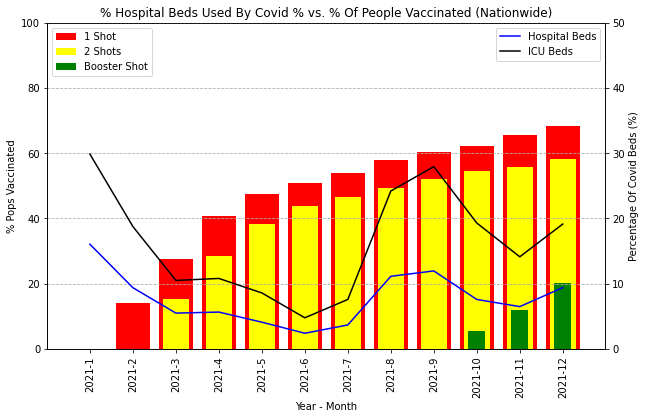

In [39]:
fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"]=[10,6]
ax1.set_xlabel("Year - Month")
ax1.tick_params(axis = "x", labelrotation = 90)
ax1.set_ylabel("% Pops Vaccinated")
ax1.bar(final_monthly_set2_df["Year-Month"], final_monthly_set2_df["%_Pops w/ 1_Vaccine_Shot"], color = "red",
        label = "1 Shot", width= 0.8)
ax1.bar(final_monthly_set2_df["Year-Month"], final_monthly_set2_df["%_Pops w/ 2_Vaccine_Shots"], color = "yellow",
        label = "2 Shots", width= 0.6)
ax1.bar(final_monthly_set2_df["Year-Month"], final_monthly_set2_df["%_Pops w/ Booster_Shot"], color = "green",
        label = "Booster Shot", width= 0.4)
ax1.set_ylim([0, 100])
ax1.legend(loc = "upper left")

ax2 = ax1.twinx()
ax2.plot(final_monthly_set2_df["Year-Month"], final_monthly_set2_df["%_Beds Used_By_Covid"], color = "blue", 
         label = "Hospital Beds")
ax2.plot(final_monthly_set2_df["Year-Month"], final_monthly_set2_df["%_ICU_Beds Used_By_Covid"], color = "black",
         label = "ICU Beds")
ax2.set_ylabel("Percentage Of Covid Beds (%)")
ax2.set_ylim([0, 50])
ax2.legend(loc = "upper right")
plt.grid(linestyle = '--')
plt.title("% Hospital Beds Used By Covid % vs. % Of People Vaccinated (Nationwide)")
plt.savefig("Figure1.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ="b",
            orientation ="landscape")
plt.show()